# All Result Plots (Random Unreliable Agents)

Plot results for unreliable agents that act randomly.

In [1]:
import csv
import os
import pathlib
import json
import pickle
from pprint import pprint
import string

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme(
    context="paper",
    style="whitegrid",
#     font_scale=2,
    rc={
        'lines.linewidth': 2,
#         'xtick.bottom': True,
#         'ytick.left': True,
        'axes.grid': True,
        'axes.grid.axis': 'both',
        'axes.grid.which': 'both'
    }
)

In [2]:
# Use latex for exporting
# mpl.use("pgf")  # can specify this as an argument to savefig() each time
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Results format

Results are stored as subfolders, each with a timestamp (e.g. `res_20220306_155424`),
in a root folder `results`.
`results` also contains a CSV called `timestamps.csv` listing the timestamps of each results folder along with configuration parameters.

Each result subfolder contains `config.json`, which gives the experimental configuration used to run experiments (must match the entry in `timestamps.csv`), and `results.json` which contains the collected data.

Each `results.json` contains a list of $N$ 2-tuples, where $N$ is the number of separate runs (each with a different random seed).
Each tuple contains the training and evaluation data respectively, each being a dictionary.
Each of these dicts are in the following key-value format: `metric : list of values over episodes` 

## Load Data

In [3]:
# Location of root folder containing all result subfolders
NUM_AGENTS = 16
# RESULTS_PATH = pathlib.Path(f"../results-{NUM_AGENTS}-agents/")
RESULTS_PATH = pathlib.Path(f"../results-unrel-random/results/")

# Names of metrics in each result folder
METRIC_NAMES = [
    'average_reward',
    'success_rate',
    'average_trust_rate',
    'mutual_trust_rate',
    'average_trust_accuracy'
]

# Convert metric names (lower case, joined by underscores) to human-readable (capitalised with spaces)
METRIC_TO_LABEL = {
    'average_reward': 'Reward',
    'average_trust_accuracy': 'Trust Accuracy',
    'average_trust_rate': 'Trust Rate',
    'mutual_trust_rate': 'Mutual Trust',
    'success_rate': 'Success Rate'
}

# Similarly, variable to human readable
VAR_TO_LABEL = {
    "noise": "$1 - p$",  # "Noise"
    "frac_reliable": "$f$" # "Reliable Fraction"
}

RUNMODE_TO_LABEL = {
    "trained": "RLTC",
    "oracle": "Oracle",
    "trust_all" : "Trust All"
}

RUNMODES = list(RUNMODE_TO_LABEL.keys())

In [4]:
# Collect data from 
all_data = []

for path in RESULTS_PATH.iterdir():
    if not path.name.startswith("res_"):
        continue
    
    timestamp = path.name
    files = {file.name for file in path.iterdir()}
    assert files == {"config.json", "results.json"}
    
    with open(path.joinpath("config.json"), "r") as f:
        config = json.load(f)
    
    with open(path.joinpath("results.json"), "r") as f:
        results = json.load(f)
    
    row = config.copy()
    row["timestamp"] = timestamp
    row["results"] = results
    
    all_data.append(row)

In [5]:
# Basic sanity check
assert len(set(row["timestamp"] for row in all_data)) == len(all_data)
assert all(all_data[0].keys() == row.keys() for row in all_data)

COLUMN_NAMES = list(sorted(all_data[0].keys()))

df_main = pd.DataFrame(all_data)
df_main.head(3)

,num_processes,frac_reliable,noise,episode_length,run_mode,step_size,discount,epsilon,epsilon_decay_factor,num_train_episodes,num_eval_episodes,unreliable_behaviour,timestamp,results
0,16,0.75,0.0,30,trained,0.03,0.999,0.3,0.9996,20000,2000,random,res_20220423_202915227525_24,"[[{'average_reward': [-13.333333333333334, -10..."
1,16,0.50,0.0,30,oracle,0.03,0.999,0.3,0.9996,20000,2000,random,res_20220423_180321567805_13,"[[{'average_reward': [], 'success_rate': [], '..."
2,16,0.25,0.2,30,trained,0.03,0.999,0.3,0.9996,20000,2000,random,res_20220423_171213778907_6,"[[{'average_reward': [-24.0, -17.5, -25.5, -23..."


In [6]:
def extract(row, metric):
    """Extract evaluation results for a particular metric."""
        
    results = row["results"]
    
    # all_train_results = []
    all_eval_results = []
    
    for train_result, eval_result in results:
        # all_train_results.append(train_result)
        all_eval_results.append(eval_result)
    
    return [item[metric] for item in all_eval_results]

# For each metric, get the raw data using extract(), then replace with averages
for metric in METRIC_NAMES:
    df_main[metric] = df_main.apply(lambda x: extract(x, metric), axis=1)
    df_main[metric] = df_main[metric].apply(lambda xs: [np.mean(x) for x in xs])

In [7]:
# Show results
# (excluding the original "results" column makes displaying faster)
df_main[df_main.columns.difference(["results"])]

,average_reward,average_trust_accuracy,average_trust_rate,discount,episode_length,epsilon,epsilon_decay_factor,frac_reliable,mutual_trust_rate,noise,num_eval_episodes,num_processes,num_train_episodes,run_mode,step_size,success_rate,timestamp,unreliable_behaviour
0,"[15.01175, 6.12775, 3.9541666666666666, 12.680...","[17.249999999999996, 20.59027777777778, 18.958...","[12.666666666666664, 12.090277777777773, 9.986...",0.999,30,0.3,0.9996,0.75,"[8.0625, 10.307692307692312, 6.249999999999999...",0.0,2000,16,20000,trained,0.03,"[30.0, 29.957166666666666, 29.448, 29.67020833...",res_20220423_202915227525_24,random
1,"[-4.686, -7.46875, -12.1405, -13.04225, 0.4327...","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....","[16.562500000000004, 15.0, 11.875000000000002,...",0.999,30,0.3,0.9996,0.50,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.0,2000,16,20000,oracle,0.03,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",res_20220423_180321567805_13,random
2,"[-18.49975, -24.37375, -19.891, -23.97425, -12...","[18.083333333333336, 23.499999999999996, 21.64...","[8.583333333333332, 6.8333333333333295, 7.3541...",0.999,30,0.3,0.9996,0.25,"[1.0, 16.0, 1.0, 15.0, 0.5, 1.0, 0.0, 1.0, 0.0...",0.2,2000,16,20000,trained,0.03,"[19.2805, 15.13375, 19.08325, 14.9055, 19.6147...",res_20220423_171213778907_6,random
3,"[10.4371875, 13.0219375, 10.36125, 9.231375, 9...","[17.000000000000004, 16.999999999999996, 16.31...","[17.000000000000004, 16.999999999999996, 16.31...",0.999,30,0.3,0.9996,1.00,"[10.041666666666668, 8.166666666666668, 10.375...",0.2,2000,16,20000,trained,0.03,"[24.14746875, 24.17896875, 24.0310625, 23.9907...",res_20220424_020648575731_42,random
4,"[-17.62475, -16.7205, -19.800125, -20.793125, ...","[22.187500000000004, 20.499999999999996, 23.37...","[12.770833333333325, 11.33333333333334, 7.125,...",0.999,30,0.3,0.9996,0.50,"[9.285714285714286, 9.571428571428573, 7.00000...",0.3,2000,16,20000,trained,0.03,"[18.4295625, 19.2511875, 17.704, 16.741625, 18...",res_20220423_194139044157_21,random
5,"[1.40325, -4.582166666666667, -4.69475, 0.6839...","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....","[25.416666666666647, 21.458333333333353, 20.83...",0.999,30,0.3,0.9996,0.75,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.2,2000,16,20000,oracle,0.03,"[24.026375, 23.72875, 24.052958333333336, 23.9...",res_20220423_220949225126_31,random
6,"[-13.9835, -15.6455, -18.21825, -18.48825, -10...","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....","[16.562500000000004, 15.0, 11.875000000000002,...",0.999,30,0.3,0.9996,0.50,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.3,2000,16,20000,oracle,0.03,"[20.998375, 21.028625, 20.8183125, 20.8786875,...",res_20220423_194327785864_22,random
7,"[10.0645, 9.8523125, 9.3896875, 9.092875, 10.3...","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.999,30,0.3,0.9996,1.00,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....",0.2,2000,16,20000,trust_all,0.03,"[24.13684375, 23.96278125, 23.92296875, 23.890...",res_20220424_021329050220_44,random
8,"[-18.19725, -22.12375, -20.05775, -20.92, -12....","[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....","[6.249999999999999, 5.0, 6.249999999999999, 4....",0.999,30,0.3,0.9996,0.25,"[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 0.0, 30.0...",0.3,2000,16,20000,oracle,0.03,"[21.2, 21.144375, 21.204375, 20.894, 20.586, 2...",res_20220423_173054199413_10,random
9,"[-20.34575, -25.1575, -21.64875, -24.18075, -1...","[22.875000000000004, 24.66666666666665, 23.395...","[9.625, 8.0, 6.770833333333332, 14.72916666666...",0.999,30,0.3,0.9996,0.25,"[15.0, 16.0, 1.0, 1.0, 15.5, 15.0, 0.0, 1.0, 0...",0.3,2000,16,20000,trained,0.03,"[16.730625, 14.41375, 16.652625, 14.65325, 16....",res_20220423_172954229893_9,random


In [8]:
# Delete unused results column
del df_main["results"]

## Plot Data

In [9]:
# Don't include rewards for now (so we get a 4-column grid)
metric_names = [name for name in METRIC_NAMES if name != "average_reward"]
assert len(metric_names) == 4

# Get the episode length (should be the same across all results)
episode_lengths = pd.unique(df_main["episode_length"])
assert len(episode_lengths) == 1
EPISODE_LENGTH = episode_lengths[0]
print(EPISODE_LENGTH)

30


In [10]:
def plot_metrics(df, metric_names, x_var="noise", control_var="frac_reliable", groupby_var="run_mode"):
    """Plot metrics in a grid.
    
    df: pandas dataframe to use
    metric_names: list of metrics labels to plot
    x_var: variable to hold constant (goes on the x axis per plot)
    control_var: control variable (fixed value per column)
    groupby_var: plot separate lines for each group, default run_mode (trained, oracle, trust_all)
    
    y_var is the metric by default, one metric per row.
    
    In the experiments, we varied both noise and frac_reliable.
    For this plot, we vary one (x_var) while keeping the other fixed (control_var).
    """

    # In the experiments, we varied both noise and frac_reliable,
    # so we vary one (X) and fix the other (control).
    control_unique_values = list(df[control_var].unique())
    control_unique_values.sort()
    
    # Manually set the x axis ticks and limits using this
    x_unique_values = list(df[x_var].unique())
    x_value_range = min(x_unique_values), max(x_unique_values)
    
    # For setting y-limits of plot
    # (all metric values `should` be between 0 and 1)
    metric_range = 0.0, 1.0
    
    # For seaborn hue_order/style_order
    groupby_values = list(df[groupby_var].unique())
    groupby_values.sort()

    fig, axs = plt.subplots(
        len(metric_names),
        len(control_unique_values),
        figsize=(16, 16),
#         tight_layout=True,
        sharex=True,
        sharey=True,
    )
    fig.subplots_adjust(left=0.0, right=1.0, wspace=0.3, hspace=0.28)

    for i, (axs_row, metric) in enumerate(zip(axs, metric_names)):

        # Expand results list to rows
        df_metric = df[[x_var, groupby_var, control_var, metric]]
        df_metric = df_metric.explode(metric).reset_index(drop=True)

        # Results are summed over timesteps.
        # Divide through to get per-timestep averages
        df_metric[metric] = df_metric[metric].astype("float64") / EPISODE_LENGTH
        
        for j, (ax, control_value) in enumerate(zip(axs_row, control_unique_values)):

            # Extract subset of data that we need from the full set
            df_plot = df_metric[df_metric[control_var] == control_value]        

            # Line plot with error band (1 stddev)
            sns.lineplot(
                ax=ax,
                data=df_plot,
                x=x_var,
                y=metric,
                hue=groupby_var,
                hue_order=groupby_values,
                ci="sd",
                style=groupby_var,
                style_order=groupby_values,
                markers=True,

                # Draw line and dots over the overlapping axis lines
                clip_on=False,
                zorder=100,
            )

            # Metric is shared across the row, so we just show y label for the first column.
            # Also convert y label to its human-readable name
            if j == 0:
                ax.set_ylabel(METRIC_TO_LABEL[metric])

            # Make the column title frac_reliable (human readable)
            if i == 0:
                ax.set_title(control_value)

            # Remove X label, because it is shared across subplots.
            # A supxlabel will be used instead
            ax.set_xlabel(None)
            
            # Remove y labels except first column
            if j > 0:
                ax.set_ylabel(None)

            # Remove legend (show a global one once)
            ax.legend([],[], frameon=False)

            # Avoid plotting beyond value ranges
            ax.set_xlim(x_value_range)
            ax.set_ylim(metric_range)

            # Set axis tickers
            ax.set_xticks(x_unique_values)
            ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
            ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
            
            # Major and minor gridlines
            ax.grid(visible=True, which='major', linewidth=1.0)
            ax.grid(visible=True, which='minor', linewidth=0.5)
            
            # Padding between tick labels and plot
            ax.xaxis.set_tick_params(pad=0.1)
            ax.yaxis.set_tick_params(pad=0.1)
            
    # Global legend
    handles, labels = ax.get_legend_handles_labels()

    # Manually convert legend to human-readable name
    for i in range(len(labels)):
        labels[i] = RUNMODE_TO_LABEL[labels[i]]
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.04))

    # Reduce the space between plots and this label
    center_x = (fig.subplotpars.left + fig.subplotpars.right) / 2
    fig.supxlabel(VAR_TO_LABEL[x_var], y=0.035, horizontalalignment='center', x=center_x);
    fig.suptitle(VAR_TO_LABEL[control_var], y=0.95, horizontalalignment='center', x=center_x)
    
    return fig, axs

### Reliable fraction vs metric (noise const.)

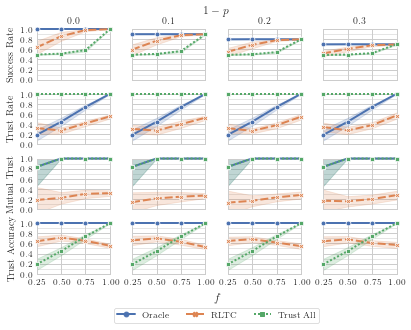

In [11]:
fig, axs = plot_metrics(df_main, metric_names, x_var="frac_reliable", control_var="noise", groupby_var="run_mode");

## Uncomment to save a copy as latex pgf format
fig.set_size_inches(w=5, h=4.5)

# fig.set_tight_layout(True)
fig.savefig(f"frac_reliable_{NUM_AGENTS}_agents_random.pgf", format="pgf", backend="pgf", bbox_inches='tight')

### Noise vs vs metric (reliable fraction const.)

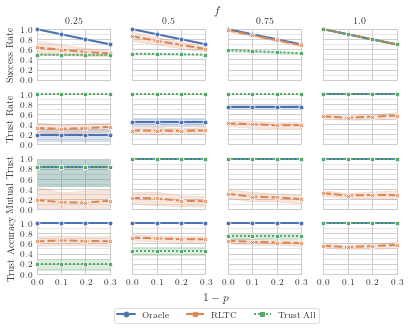

In [12]:
fig, axs = plot_metrics(df_main, metric_names, x_var="noise", control_var="frac_reliable", groupby_var="run_mode");

## Uncomment to save a copy as latex pgf format
fig.set_size_inches(w=5, h=4.5)
# fig.set_tight_layout(True)
fig.savefig(f"noise_{NUM_AGENTS}_agents_random.pgf", format="pgf", backend="pgf", bbox_inches='tight')

### Other

In [13]:
# Expand results list to rows
x_var = "frac_reliable"
groupby_var = "run_mode"
control_var = "noise"
metric = "success_rate"

df = df_main
df_metric = df[[x_var, groupby_var, control_var, metric]]
df_metric = df_metric.explode(metric).reset_index(drop=True)

# Results are summed over timesteps.
# Divide through to get per-timestep averages
df_metric[metric] = df_metric[metric].astype("float64") / EPISODE_LENGTH

In [14]:
# Rough estimate of average improvement where there are unreliable agents present.
results = df_metric[df_metric["frac_reliable"] < 1].groupby(groupby_var).agg({
    metric: {'mean'}
})
results

,success_rate
,mean
run_mode,
oracle,0.850016
trained,0.711953
trust_all,0.517658


In [15]:
# Percentage point difference
results.loc["trained", ("success_rate", "mean")] - results.loc["trust_all", ("success_rate", "mean")]

0.19429584297839497